# Tests comparing models using capymoa

## Installation:
See https://capymoa.org/


```
# CapyMOA requires Java. This checks if you have it installed
java -version

# Install java on ubuntu with sudo apt install openjdk-default

# CapyMOA requires PyTorch. This installs the CPU version
pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

# Install CapyMOA and its dependencies
pip install capymoa

# Check that the install worked
python -c "import capymoa; print(capymoa.__version__)"
```

Import Modules

In [1]:
from capymoa.regressor import KNNRegressor, AdaptiveRandomForestRegressor
from capymoa.stream._stream import NumpyStream
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint  # Import pprint module

Load the Data:




In [3]:
path_to_csv = Path("../power_plant/MHPA-docs-data.csv")
x_features = pd.read_csv(path_to_csv).fillna(0).to_numpy()

There are the following columns:
```
0       1       2        3                4                     5           6           7   
TmStamp,RecNum,batt_volt,mean_wind_speed,mean_wind_direction,std_wind_dir,Max_Gust_Min,Max_Gust_Hr,

8        9              10            11       12     13        14              15
Rain_mm,Barametric_Avg,Air_Temp_Avg,RH_Avg,SlrW_Avg,SlrMJ_Tot,in_bytes_str,Dew_Point_Avg
```


- `TmStamp` is a timestamp, and may be helpful for training (if the model can learn the seasons from it or something)
- `RecNum` is basically the same as timestamp, but it gets reset to zero sometimes
- `SlrW_Avg` is the column we are trying to predict
- `SlrMJ_Tot` is the same as SlrW_Avg, so it needs to be removed from the data
- `in_bytes_str` seems to have some metadata, it's a string e.g `"Q,116,002.68,M,00,_x0003_14"` . For now we can try by just removing it



In [4]:
# Seperate out the target variable (what we are trying to predict)
class_index: int = 12,  # slrw_avg
targets = x_features[:, class_index]

# remove slrw_avg, slrmj_tot, recnum, tmstamp from x_features, so they are not used as features

x_features = np.delete(x_features, -2, axis=1) # remove in_bytes_str
x_features = np.delete(x_features, class_index, axis=1) # remove slrw_avg
x_features = np.delete(x_features, class_index, axis=1) # remove slrmj_tot
x_features = np.delete(x_features, 0, axis=1) # remove recnum
x_features = np.delete(x_features, 0, axis=1) # remove tmstamp

Now we can create a CapyMoa stream from the data

In [6]:
stream = NumpyStream(
    x_features,
    targets,
    target_type="numeric", # "numeric" or "categorical", we are doing regression
    feature_names=["batt_volt", "mean_wind_speed", "mean_wind_direction", "std_wind_dir", "Max_Gust_Min", "Max_Gust_Hr","Rain_mm","Barametric_Avg","Air_Temp_Avg","RH_Avg","Dew_Point_Avg"],
)

Create some learner models to test

In [7]:
ARF_learner = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=10)
knnreg = KNNRegressor(schema=stream.get_schema(), k=3, window_size=1000)

Evaluate with prequential evaluation

In [ ]:
# This takes like 4 mins to run
results_arf = prequential_evaluation(stream=stream, learner=ARF_learner, window_size=5000)

Print the results

In [9]:
pprint(results_arf['windowed'].metrics_per_window())
pprint(results_arf)

     classified instances  mean absolute error  root mean squared error  \
0                  5000.0            23.394113                44.046230   
1                  5000.0            17.580400                41.863500   
2                  5000.0            28.043855                53.509284   
3                  5000.0            17.428089                34.229112   
4                  5000.0            29.685859                49.297321   
..                    ...                  ...                      ...   
205                5000.0            23.248841                49.493419   
206                5000.0            34.111339                76.904339   
207                5000.0            38.845166                76.138230   
208                5000.0            41.229433                84.259700   
209                5000.0            23.691988                60.856660   

     relative mean absolute error  relative root mean squared error  \
0                        0.1

Display the evaluation results

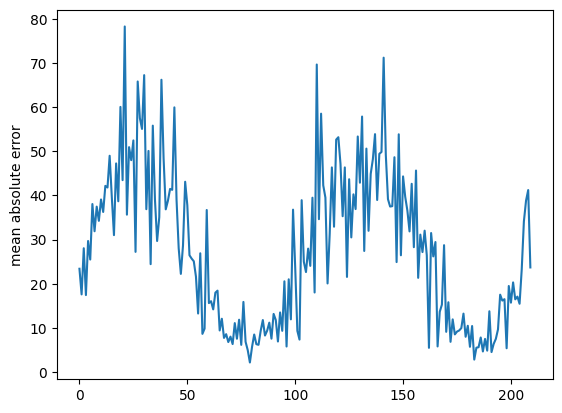

<Axes: ylabel='relative mean absolute error'>

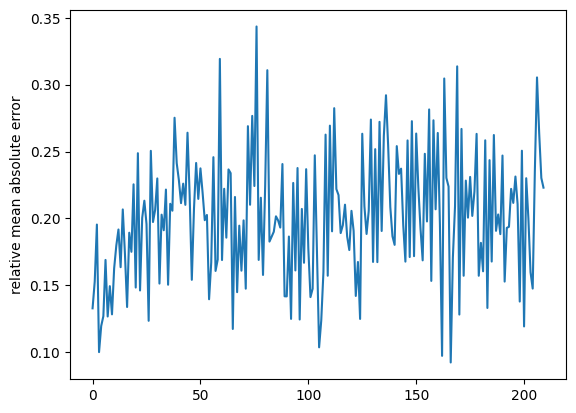

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(results_arf['windowed'].metrics_per_window()["mean absolute error"])
plt.show()
sns.lineplot(results_arf['windowed'].metrics_per_window()["relative mean absolute error"])
plt.show()

In [27]:
# this also takes like 5 mins
results_knn = prequential_evaluation(stream=stream, learner=knnreg, window_size=5000)

<Axes: ylabel='mean absolute error'>

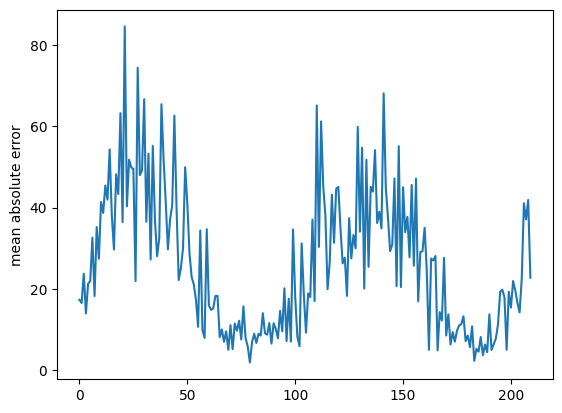

In [28]:
sns.lineplot(results_knn['windowed'].metrics_per_window()["mean absolute error"])

# Testing and plotting a bunch of regressors all at once




In [29]:
from capymoa.regressor import SOKNLBT, SGDRegressor, PassiveAggressiveRegressor, ORTO, ARFFIMTDD


schema = stream.get_schema()
regressors = {
    "KNN": KNNRegressor(schema=schema, k=3, window_size=500),
    "ARF": AdaptiveRandomForestRegressor(schema=schema, ensemble_size=10),
    "SOKNLBT": SOKNLBT(schema),
    "SGD": SGDRegressor(schema),
    "PassiveAgressive": PassiveAggressiveRegressor(schema),
    "Orto": ORTO(schema),
    "ARFFIMTDD": ARFFIMTDD(schema),
}

In [31]:
results = []

for name, learner in regressors.items():
    print(f"Running {name}")
    result = prequential_evaluation(stream=stream, learner=learner, window_size=5000)
    print(f"Done in {results['cpu_time']} secs")
    results.append((name, result))

print("Done")

Running KNN
Running ARF
Running SOKNLBT
Running SGD


/home/bert/miniconda3/lib/python3.11/site-packages/capymoa/evaluation/evaluation.py:268: UserWarning: The learner did not produce a prediction for this instance
  warnings.warn("The learner did not produce a prediction for this instance")


Running PassiveAgressive


/home/bert/miniconda3/lib/python3.11/site-packages/capymoa/evaluation/evaluation.py:268: UserWarning: The learner did not produce a prediction for this instance
  warnings.warn("The learner did not produce a prediction for this instance")


Running Orto
Running ARFFIMTDD
Done


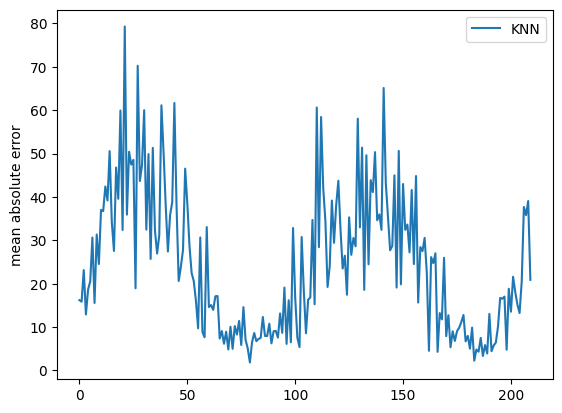

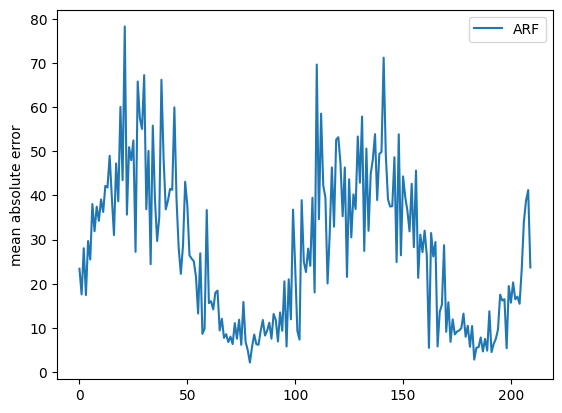

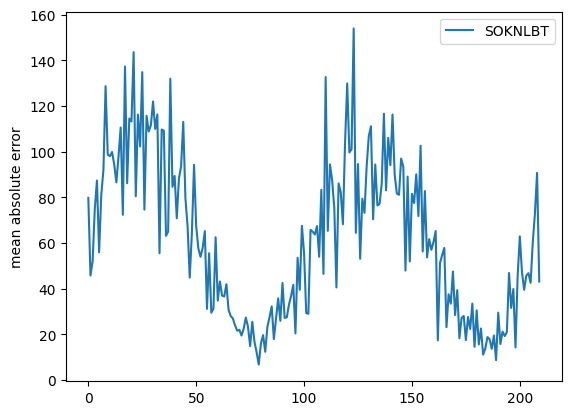

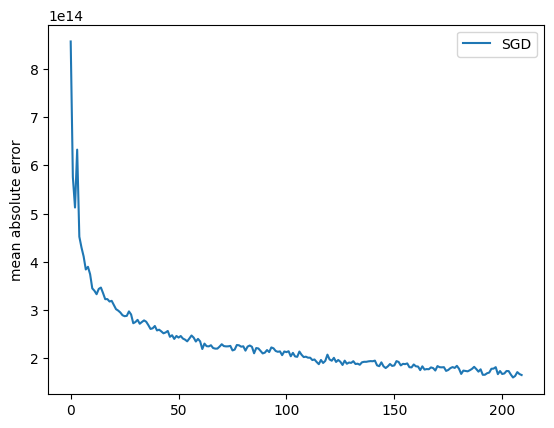

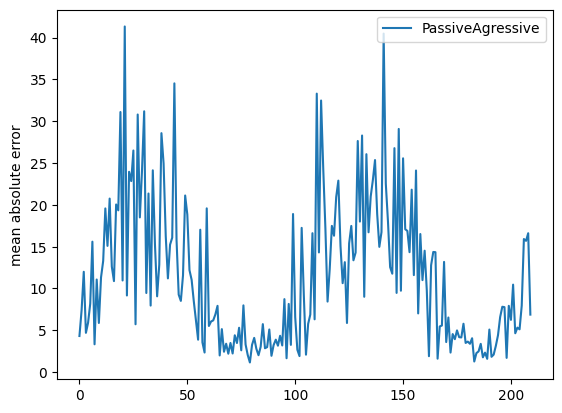

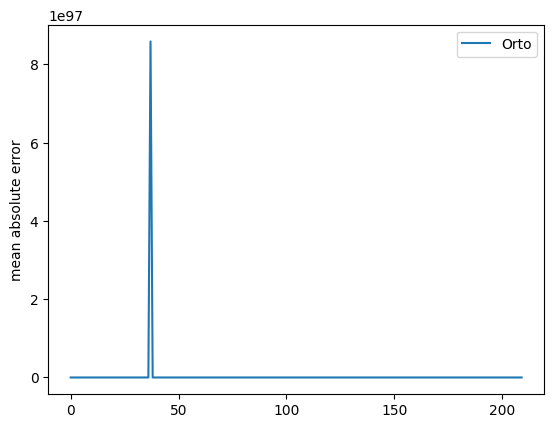

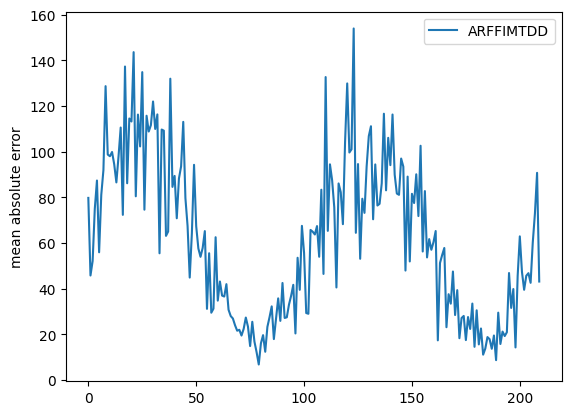

In [52]:
for name, result in results:
    
    sns.lineplot(result['windowed'].metrics_per_window()["mean absolute error"], label=name)
    plt.show()



In [55]:

from pid_regressor import PIDRegressor, LastGuessRegressor
reg = PIDRegressor(schema=stream.get_schema())

res = prequential_evaluation(stream=stream, learner=knnreg, window_size=5000)
sns.lineplot(res['windowed'].metrics_per_window()["mean absolute error"], label=name)


TypeError: descriptor '__init__' of 'super' object needs an argument